In [86]:
!pip install numpy pandas matplotlib scikit-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 668.8 kB/s eta 0:00:00m eta 0:00:010:00:11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 213.8 kB/s eta 0:00:00m eta 0:00:010:00:19


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Part 1: Exploratory Data Analysis (EDA)

# 1. Load the dataset and display basic information (rows, columns, data types).
df = pd.read_csv('batch_and_sensor_next.csv')

print(f"Dataset dimensions: {df.shape}")
print(f"Data types:\n{df.dtypes}")

Dataset dimensions: (190, 55)
Data types:
equipment_id                               object
recipe_first                               object
recipe_last                                object
batch_id_last                              object
start_time_last                            object
end_time_first                             object
failure_first                               int64
failure_last                                int64
sensor_0_sensor_value_avg_min_first       float64
sensor_0_sensor_value_avg_max_first       float64
sensor_0_sensor_value_avg_count_first       int64
sensor_0_sensor_value_avg_avg_first       float64
sensor_0_sensor_value_avg_stddev_first    float64
sensor_1_sensor_value_avg_min_first       float64
sensor_1_sensor_value_avg_max_first       float64
sensor_1_sensor_value_avg_count_first       int64
sensor_1_sensor_value_avg_avg_first       float64
sensor_1_sensor_value_avg_stddev_first    float64
sensor_2_sensor_value_avg_min_first       float64
sensor_2

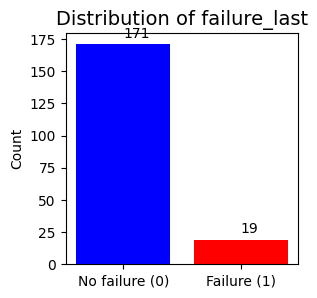

failure_last
0    171
1     19
Name: count, dtype: int64


In [3]:
# 2. Show the distribution of the target variable (failure_last).
plt.figure(figsize=(3, 3))
labels = ['No failure (0)', 'Failure (1)']
counts = df['failure_last'].value_counts()
plt.bar(labels, counts, color=['blue', 'red'])
plt.title('Distribution of failure_last', fontsize=14)
plt.ylabel('Count')
for i, count in enumerate(counts): plt.text(i, count + 5, str(count))
plt.show()

print(counts)

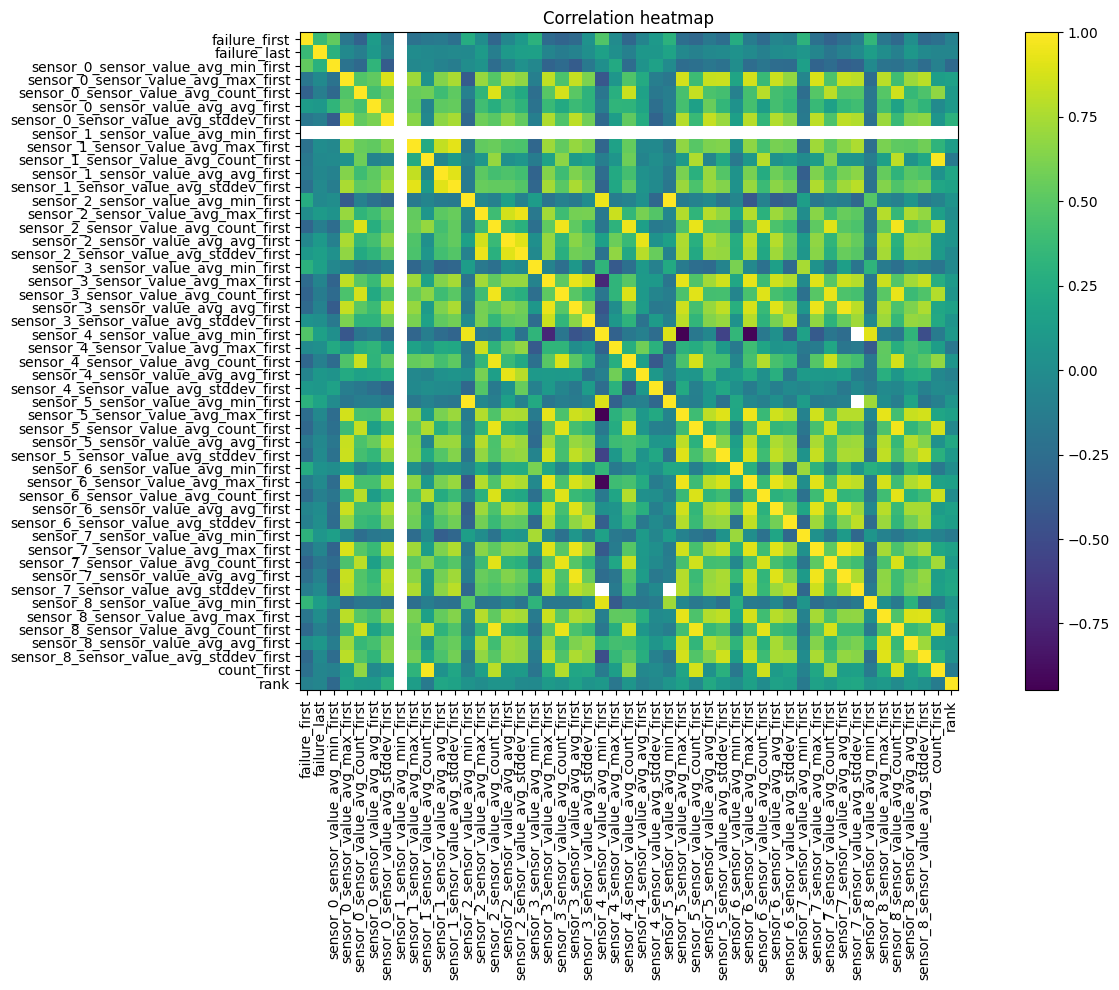

In [4]:
# 3. Create a correlation heatmap for numerical features.
# Filter all numeric features in dataset
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
# Get correlation matrix
cm = df[num_cols].corr()

# Plot
plt.figure(figsize=(15, 10))
ims = plt.imshow(cm)
plt.colorbar(ims)
plt.title('Correlation heatmap')
plt.xticks(range(len(cm.columns)), cm.columns, rotation=90)
plt.yticks(range(len(cm.columns)), cm.columns)
plt.tight_layout()
plt.show()
plt.close()

In [5]:
# 4. Identify the top 3 features most correlated with failure_last.

# Get the correlations of failure_last from correlation matrix in step 3 then drop itself
failure_last_corrs = cm['failure_last'].drop('failure_last')
# Descending sort and get first 3 features
top3_corrs = failure_last_corrs.sort_values(ascending=False).head(3)
print("Top 3 features most correlated with failure_last:")
print(top3_corrs)

Top 3 features most correlated with failure_last:
failure_first                          0.371424
sensor_0_sensor_value_avg_min_first    0.297659
sensor_5_sensor_value_avg_min_first    0.185222
Name: failure_last, dtype: float64


In [6]:
# Part 2: XGBoost Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc



In [7]:
# 1. Prepare the data:
#    - Handle any missing values.
df2 = df.copy()
num_cols = df2.select_dtypes(include=['float64', 'int64']).columns
df2[num_cols] = df2[num_cols].fillna(df2[num_cols].mean()) # Fill missing values of each column with the mean value of that column

In [8]:
#    - Encode categorical variables if necessary.

# Get all categorical columns
cate_cols = df.select_dtypes(include=['object']).columns
# And skip this columns
skip_cols = ['batch_id_last', 'start_time_last', 'end_time_first'] 
cols_to_encode = [col for col in cate_cols if col not in skip_cols]
    
# Encode categorical variables
encoders = {}
for col in cols_to_encode:
    le = LabelEncoder()
    df2[col] = le.fit_transform(df2[col])
    encoders[col] = le

In [9]:
#    - Split data into 80% training and 20% testing sets.

X = df2.drop(['failure_last', 'batch_id_last', 'start_time_last', 'end_time_first'], axis=1)
y = df2['failure_last']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1998, stratify=y)
print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")



Train set: (152, 51)
Test set: (38, 51)


In [10]:
# 2. Train an XGBoost model
xgbclassifier = xgb.XGBClassifier(objective='binary:logistic')
xgbclassifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
# Predict on test set
y_pred = xgbclassifier.predict(X_test)

In [15]:
# 3. Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

Accuracy: 0.8947
Precision: 0.5000
Recall: 0.2500
F1-score: 0.3333


In [16]:
# Nhận xét:
# Accuracy: Mô hình dự đoán đúng ~ 89% các trường hợp
# Precision: Trong các dự đoán là failure, chỉ có 50% là failure thực sự
# Recall: Mô hình chỉ phát hiện được 25% failure trong tập dữ liệu test
# F1-score: thấp (0.3333) thể hiện mô hình chưa tốt trong việc dự đoán failure

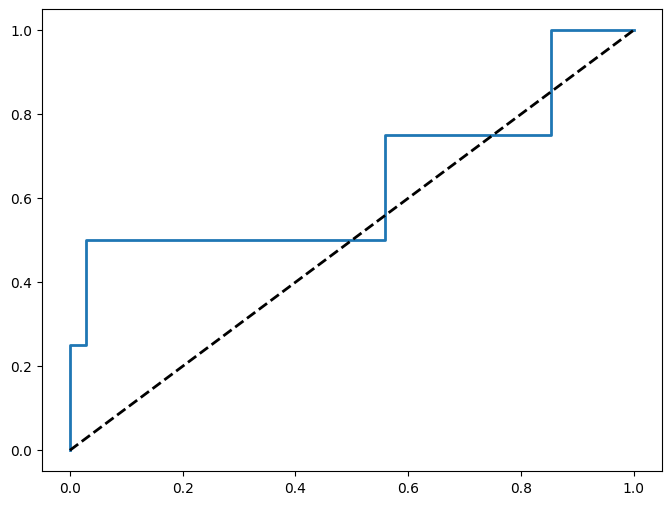


AUC Score: 0.6397


In [17]:
# ROC curve and AUC score
y_pred_proba = xgbclassifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.show()
plt.close()

print(f"\nAUC Score: {roc_auc:.4f}")


sensor_7_sensor_value_avg_stddev_first: 0.1664
sensor_6_sensor_value_avg_stddev_first: 0.0771
rank: 0.0709
sensor_7_sensor_value_avg_count_first: 0.0683
sensor_2_sensor_value_avg_count_first: 0.0563


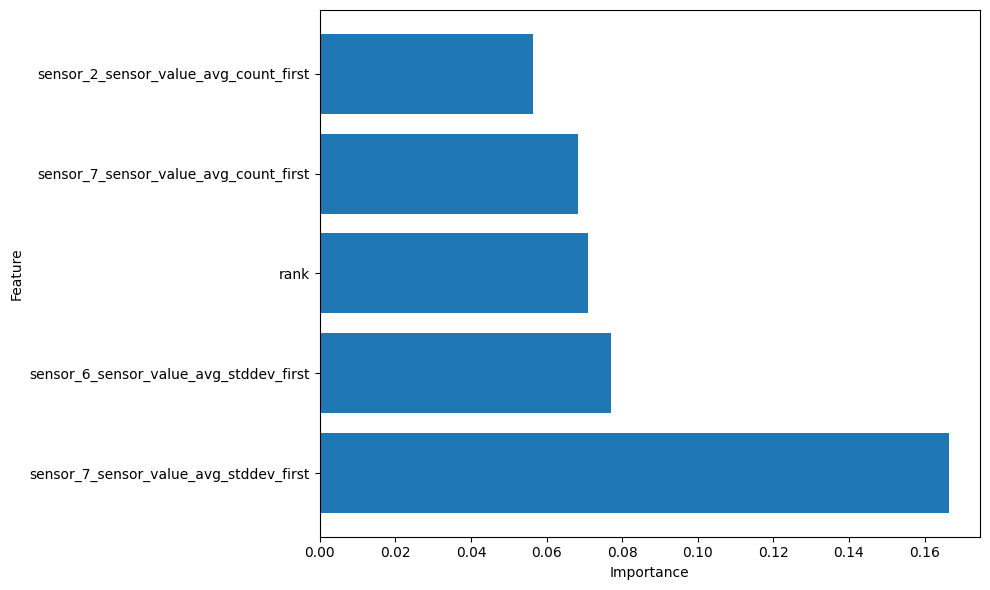

In [18]:
# 4. Feature Importance
feature_importance = xgbclassifier.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False).head(5)

for i, row in importance_df.iterrows(): print(f"{row['Feature']}: {row['Importance']:.4f}")

# - Plot the top 5 most important features.
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
plt.close()

In [19]:
# Explain significance

# Get correlation of feature to failure_last feature
for feature in importance_df['Feature'][:5]:
    correlation = cm.loc[feature, 'failure_last'] if feature in cm.index else "N/A"
    print(f"{feature}: Correlation with failure_last = {correlation}")

sensor_7_sensor_value_avg_stddev_first: Correlation with failure_last = -0.012120572370665045
sensor_6_sensor_value_avg_stddev_first: Correlation with failure_last = 0.017042469144200358
rank: Correlation with failure_last = -0.06213081844509519
sensor_7_sensor_value_avg_count_first: Correlation with failure_last = -0.17872060865373396
sensor_2_sensor_value_avg_count_first: Correlation with failure_last = -0.11489805820746858


In [20]:
# Giải thích:

# sensor_7_sensor_value_avg_stddev_first:
# feature importance: 0.1664 (cao thứ nhất)
# correlation: -0.012120572370665045 (khá thấp)

# sensor_6_sensor_value_avg_stddev_first:
# feature importance: 0.0771 (cao thứ 2)
# correlation: 0.017042469144200358 (khá thấp)

# rank:
# feature importance: 0.0709 (cao thứ 3)
# correlation: -0.06213081844509519 (khá thấp)

# sensor_7_sensor_value_avg_count_first:
# feature importance: 0.0683 (cao thứ 4)
# correlation: -0.17872060865373396 (cao nhất)

# sensor_2_sensor_value_avg_count_first:
# feature importance: 0.0563 (thấp nhất)
# correlation: -0.11489805820746858 (cao thứ 2)

In [21]:
# Bonus (if time permits):
# Implement one technique to improve the model's performance (e.g., handle class imbalance or basic hyperparameter tuning).

# Note: Provide concise comments in your code to explain your approach. 
# Total time: 60 minutes
# Version 3 of 3